## Prepare the workspace

In [1]:
# Before we proceed, we need to update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2)
ERROR: No matching distribution found for torch==1.0.0


In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of our overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, we will train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice, we'd train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, and you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on our dataset
* Use the trained classifier to predict image content

After completing this project, we'll have an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application. But, what we do with our new skills depends on our imagination and effort in building a dataset. For example, imagine an app where we take a picture of a car, it tells us what the make and model is, then looks up information about it. We will have to build our own dataset and make something new.

First up is importing the packages we need. It's good practice to keep all the imports at the beginning of the code.

In [87]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import numpy as np

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

## Data Description

The dataset is split into three parts: training, validation, and testing. For our training, we'll apply transformations such as random scaling, cropping, and flipping. This will help our network generalize, leading to better performance. We also need to ensure that the input data is resized to 224x224 pixels, as required by the pre-trained networks.

The validation and testing sets are used to measure our model's performance on data it hasn't seen yet. For these sets, we don't want any scaling or rotation transformations, but we'll need to resize and then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset, where each color channel was normalized separately. For all three sets, we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]`, and for the standard deviations, `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [8]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Define our transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

### Label mapping

We'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object that we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will provide us with a dictionary mapping the integer-encoded categories to the actual names of the flowers.

In [72]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Let's build and train a new feed-forward classifier using those features.

Things we'll need to do:

* Load a pre-trained network 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [12]:
model = models.vgg11(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /home/student/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 261MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in model.parameters():
    param.requires_grad = False
    
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 128)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(128, 102)),
                          ('output', nn.LogSoftmax(dim=1))
]))
criterion = nn.NLLLoss()
model.classifier = classifier

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device);

In [15]:
epochs = 3 
for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    else:
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model.forward(inputs)
                valid_loss += criterion(output,labels)
                
                ps = torch.exp(output)
                top, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Valid Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
        model.train()
                                
                    
                    
                    
        

Epoch: 1/3..  Training Loss: 2.507..  Valid Loss: 1.130..  Test Accuracy: 0.700
Epoch: 2/3..  Training Loss: 1.473..  Valid Loss: 0.956..  Test Accuracy: 0.761
Epoch: 3/3..  Training Loss: 1.285..  Valid Loss: 0.880..  Test Accuracy: 0.790


## Testing our network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate of the model's performance on completely new images. Let's run the test images through the network and measure the accuracy, the same way we did during validation. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
accuracy = 0
test_loss = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)
            test_loss += criterion(output,labels)
            
            ps = torch.exp(output)
            top, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
    f"Test accuracy: {accuracy/len(testloader):.3f}")

Test loss: 0.919.. Test accuracy: 0.760


## Save the checkpoint

Now that our network is trained, let's save the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute, making inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Let's make sure to include any information we need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. We'll likely want to use this trained model in the next part of the project, so it's best to save it now.

In [ ]:
# Save the checkpoint 
model.class_to_idx = train_data.class_to_idx

checkpoint = {
    'input_size':25088,
    'ouput_size':102,
    'hidden_layers':[256, 128],
    'architecture': 'vgg11',
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'epochs': epochs,
    'optimizer_state_dict': optimizer.state_dict()
}

In [43]:
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point, it's good to write a function that can load a checkpoint and rebuild the model. This way, we can come back to this project and keep working on it without having to retrain the network.

In [5]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    # Load the pre-trained model architecture
    model = models.vgg11(pretrained=True)
    
    # Freeze the pre-trained model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Load the saved model state dictionary     
    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0])),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][-1])),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(checkpoint['hidden_layers'][-1], checkpoint['ouput_size'])),
                          ('output', nn.LogSoftmax(dim=1))
                        ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    # Load the class to index mapping
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [19]:
new_model = load_checkpoint('checkpoint.pth')
new_model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Inference for classification

Now, let's write a function to use a trained network for inference. We'll create a function called `predict` that takes an image and a model, then returns the top 𝐾 most likely classes along with the probabilities. It should look like:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [0.01558163, 0.01541934, 0.01452626, 0.01443549, 0.01407339]
> ['70', '3', '45', '62', '55']
```

First, we'll need to handle processing the input image so that it can be used in our network.

## Image Preprocessing

We'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, we'll resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expects floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]`, and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [113]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    from PIL import Image
    
    
    im = Image.open(image)
    im.thumbnail((256,256))
    
    width, height = im.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2

    im = im.crop((left, top, right, bottom))
    
    np_image = np.array(im)/255
    
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])

    np_image = (np_image - means) / stds
    

    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image
    


To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [1]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
#     image = image.numpy().transpose((1, 2, 0))
    image = np.transpose(image, (1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities and then find the $K$ largest values.

To get the top $K$ largest values in a tensor, we'll use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx`, which we hopefully added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Let's make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [0.01558163, 0.01541934, 0.01452626, 0.01443549, 0.01407339]
> ['70', '3', '45', '62', '55']
```

In [115]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    image = torch.from_numpy(np.array([image])).float()
    model = model.to('cuda')
    image = image.to('cuda')
    model.eval()
    with torch.no_grad():
        output = model.forward(image)
        
    probability = torch.exp(output)
    
    top_probs, top_indices = probability.topk(topk)
    
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    top_classes = [idx_to_class[idx.item()] for idx in top_indices[0]]
    
    return top_probs.float(), top_classes
        

## Sanity Checking

Now that we can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (which should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, we'll use the `imshow` function defined above.

In [117]:
image = './flowers/test/10/image_07104.jpg'
model = load_checkpoint('checkpoint.pth')
probability, classes = predict(image,model,5)

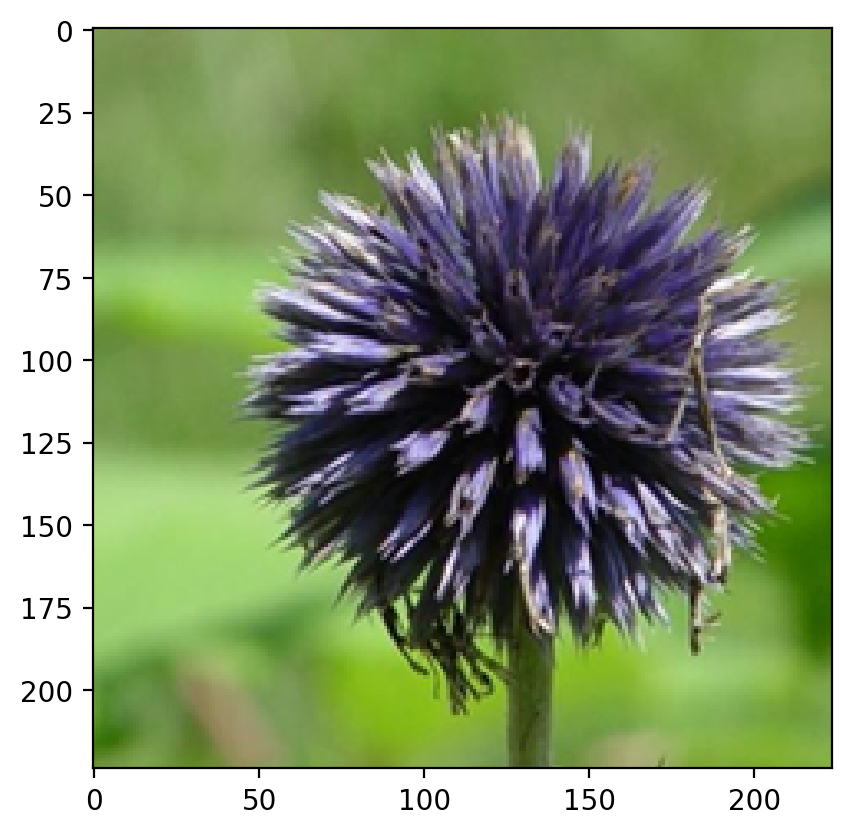

In [118]:
# Display an image along with the top 5 classesmodel
img = process_image(image)
show_img = imshow(img)

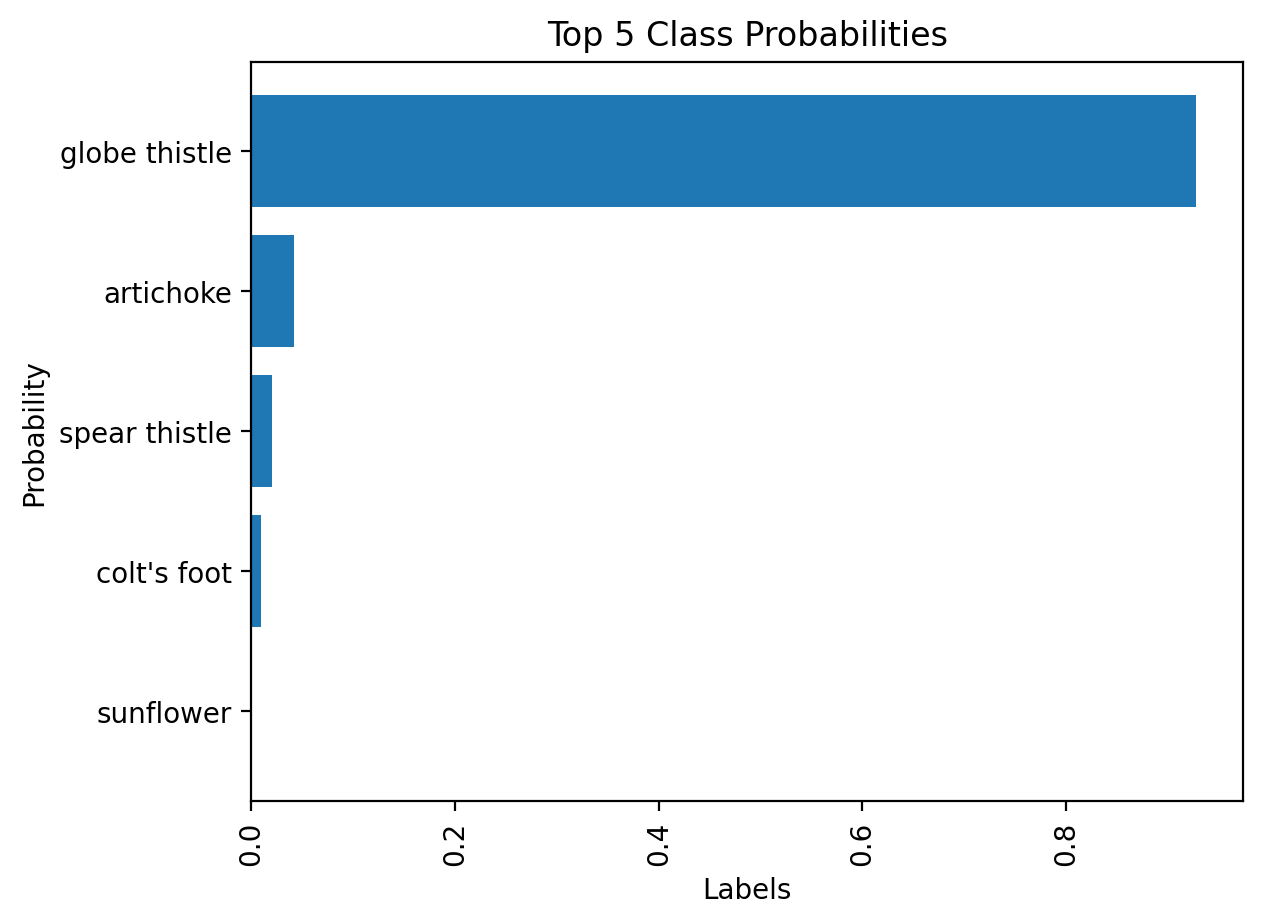

In [119]:
probs = probability.tolist()[0]

labels = [cat_to_name[class_idx] for class_idx in classes]


prob, label = zip(*sorted(zip(probs, labels), reverse=False))
plt.barh(label, prob)


plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Top 5 Class Probabilities')


plt.xticks(rotation=90)

# Display the plot
plt.show()